# CSE 455 final project
## Member: Bertol Kensese, Jessie Ren
## Source: https://www.kaggle.com/code/wasdac/dogs-vs-cats-transfer-learning

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import zipfile
import os
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Extract zip file

In [ ]:
z= zipfile.ZipFile('/content/drive/MyDrive/CSE455/train.zip')
z.extractall()

In [ ]:
filepath_train = os.listdir("./train")

## Prepare file path and split training data

In [ ]:
os.mkdir("./data")
os.mkdir("./data/train_data")
os.mkdir("./data/train_data/cats")
os.mkdir("./data/train_data/dogs")

In [ ]:
os.mkdir("./data/val_data")
os.mkdir("./data/val_data/cats")
os.mkdir("./data/val_data/dogs")

In [ ]:
train_data_root = "./data/train_data"
cats_train_folder = "./data/train_data/cats"
dogs_train_folder = "./data/train_data/dogs"

val_data_root = "./data/val_data"
cats_val_folder = "./data/val_data/cats"         
dogs_val_folder = "./data/val_data/dogs"

In [ ]:
cat=0
dog=0
others=0
total_len=0
for i in tqdm(filepath_train):
    src = os.path.join("./train",i)
    if i.split(".")[0]== "cat":
        cat+=1
        shutil.copy(src,cats_train_folder)
    else:
        dog+=1
        shutil.copy(src,dogs_train_folder)

100%|██████████| 25000/25000 [00:03<00:00, 7140.56it/s]


In [ ]:
cat_train_images = os.listdir(cats_train_folder)
dog_train_images = os.listdir(dogs_train_folder)

In [ ]:
val_cat_images = cat_train_images[-int((len(cat_train_images)*0.2)):]
src = cats_train_folder
destination = cats_val_folder
for cat in val_cat_images:
    shutil.move(os.path.join(src,cat),destination)

In [ ]:
val_dog_images = dog_train_images[-int((len(dog_train_images)*0.2)):]
src = dogs_train_folder
destination = dogs_val_folder
for dog in val_dog_images:
    shutil.move(os.path.join(src,dog),destination)

## Prepare data for ResNet and DenseNet

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
data_dir = "./data"
sets = ['train_data', 'val_data']

In [54]:
torch.manual_seed(1)
train_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.RandomHorizontalFlip(0.5)])

val_transform = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                    ])

data_transforms = {
    "train_data": train_transform,
    "val_data": val_transform
}

In [55]:
image_datasets = {x: ImageFolder(os.path.join(data_dir,x), transform=data_transforms[x]) for x in ["train_data","val_data"]}

In [56]:
torch.manual_seed(1)
dataloaders = {x: DataLoader(image_datasets[x],batch_size=16,shuffle=True) for x in ["train_data","val_data"]}

## Training function

In [79]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    torch.manual_seed(1)
    
    best_acc = 0.0

    train_loss = []
    val_loss = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        
        for phase in ['train_data', 'val_data']:
            if phase == 'train_data':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

           
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train_data'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    
                    if phase == 'train_data':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train_data':
                scheduler.step()

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == "train_data":
                train_loss.append(epoch_loss)
            else:
                val_loss.append(epoch_loss)
             
            if phase == 'val_data' and epoch_acc > best_acc:
                best_acc = epoch_acc

    print('Best val Acc: {:4f}'.format(best_acc))

    
    return model, train_loss, val_loss

## First model: transfer learning from resnet 18 using SGD, momentum = 0.25, lr=0.01 with decay gamma = 0.1 and step size 4

In [74]:
torch.manual_seed(1)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = 0.25)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [75]:
torch.manual_seed(1)
model, training_loss, validation_loss = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=7)

Epoch 1/7
----------
train_data Loss: 0.0842 Acc: 0.9677
val_data Loss: 0.0372 Acc: 0.9888
Epoch 2/7
----------
train_data Loss: 0.0433 Acc: 0.9845
val_data Loss: 0.0363 Acc: 0.9876
Epoch 3/7
----------
train_data Loss: 0.0266 Acc: 0.9909
val_data Loss: 0.0340 Acc: 0.9894
Epoch 4/7
----------
train_data Loss: 0.0164 Acc: 0.9943
val_data Loss: 0.0371 Acc: 0.9888
Epoch 5/7
----------
train_data Loss: 0.0097 Acc: 0.9973
val_data Loss: 0.0319 Acc: 0.9916
Epoch 6/7
----------
train_data Loss: 0.0094 Acc: 0.9977
val_data Loss: 0.0324 Acc: 0.9910
Epoch 7/7
----------
train_data Loss: 0.0071 Acc: 0.9979
val_data Loss: 0.0313 Acc: 0.9920
Best val Acc: 0.992000


In [82]:
FILE = "dogs_vs_cats_resnet18_sgd.pth"
torch.save(model.state_dict(),FILE)

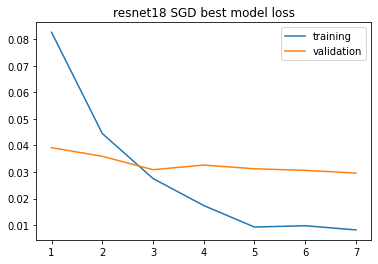

In [87]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.arange(1,8), training_loss, label = "training")
plt.plot(np.arange(1,8), validation_loss, label = "validation")
plt.title("resnet18 SGD best model loss")
plt.legend()

## Second model: transfer learning from resnet 18 using RMSprop, momentum = 0.1, lr = 0.00001 with decay gamma = 0.1 and step size 5

In [135]:
torch.manual_seed(1)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr = 0.00001, momentum = 0.1)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [136]:
torch.manual_seed(1)
model, training_loss, validation_loss = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=9)

Epoch 1/9
----------
train_data Loss: 0.0829 Acc: 0.9698
val_data Loss: 0.0411 Acc: 0.9872
Epoch 2/9
----------
train_data Loss: 0.0449 Acc: 0.9835
val_data Loss: 0.0330 Acc: 0.9898
Epoch 3/9
----------
train_data Loss: 0.0282 Acc: 0.9907
val_data Loss: 0.0314 Acc: 0.9900
Epoch 4/9
----------
train_data Loss: 0.0188 Acc: 0.9940
val_data Loss: 0.0313 Acc: 0.9902
Epoch 5/9
----------
train_data Loss: 0.0134 Acc: 0.9962
val_data Loss: 0.0325 Acc: 0.9912
Epoch 6/9
----------
train_data Loss: 0.0088 Acc: 0.9978
val_data Loss: 0.0302 Acc: 0.9916
Epoch 7/9
----------
train_data Loss: 0.0083 Acc: 0.9980
val_data Loss: 0.0289 Acc: 0.9916
Epoch 8/9
----------
train_data Loss: 0.0069 Acc: 0.9980
val_data Loss: 0.0283 Acc: 0.9918
Epoch 9/9
----------
train_data Loss: 0.0072 Acc: 0.9983
val_data Loss: 0.0279 Acc: 0.9926
Best val Acc: 0.992600


In [137]:
FILE = "dogs_vs_cats_resnet18_rmsprop.pth"
torch.save(model.state_dict(),FILE)

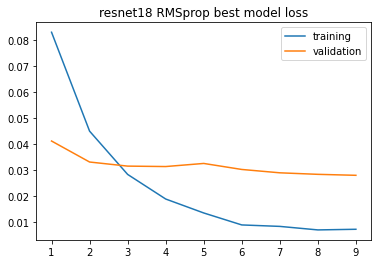

In [138]:
plt.figure()
plt.plot(np.arange(1,10), training_loss, label = "training")
plt.plot(np.arange(1,10), validation_loss, label = "validation")
plt.title("resnet18 RMSprop best model loss")
plt.legend()

## Third model: transfer learning from resnet 18 using Adam, lr = 0.00001

In [129]:
torch.manual_seed(1)
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [130]:
torch.manual_seed(1)
model, training_loss, validation_loss = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=3)

Epoch 1/3
----------
train_data Loss: 0.1056 Acc: 0.9621
val_data Loss: 0.0425 Acc: 0.9862
Epoch 2/3
----------
train_data Loss: 0.0490 Acc: 0.9824
val_data Loss: 0.0329 Acc: 0.9896
Epoch 3/3
----------
train_data Loss: 0.0314 Acc: 0.9891
val_data Loss: 0.0317 Acc: 0.9908
Best val Acc: 0.990800


In [131]:
FILE = "dogs_vs_cats_resnet18_adam.pth"
torch.save(model.state_dict(),FILE)

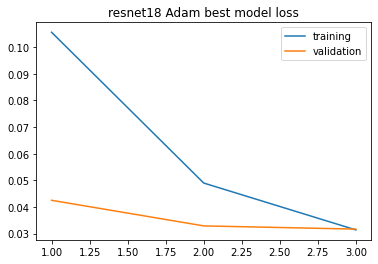

In [132]:
plt.figure()
plt.plot(np.arange(1,4), training_loss, label = "training")
plt.plot(np.arange(1,4), validation_loss, label = "validation")
plt.title("resnet18 Adam best model loss")
plt.legend()

## Fourth model: transfer learning from densenet 121 using SGD, lr=0.01 with decay gamma = 0.1 and step size 3

In [158]:
torch.manual_seed(1)
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [159]:
torch.manual_seed(1)
model, training_loss, validation_loss = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=6)

Epoch 1/6
----------
train_data Loss: 0.0575 Acc: 0.9776
val_data Loss: 0.0483 Acc: 0.9844
Epoch 2/6
----------
train_data Loss: 0.0250 Acc: 0.9909
val_data Loss: 0.0246 Acc: 0.9916
Epoch 3/6
----------
train_data Loss: 0.0144 Acc: 0.9956
val_data Loss: 0.0260 Acc: 0.9904
Epoch 4/6
----------
train_data Loss: 0.0070 Acc: 0.9982
val_data Loss: 0.0208 Acc: 0.9930
Epoch 5/6
----------
train_data Loss: 0.0062 Acc: 0.9989
val_data Loss: 0.0198 Acc: 0.9936
Epoch 6/6
----------
train_data Loss: 0.0050 Acc: 0.9990
val_data Loss: 0.0200 Acc: 0.9938
Best val Acc: 0.993800


In [160]:
FILE = "dogs_vs_cats_densenet121_sgd.pth"
torch.save(model.state_dict(),FILE)

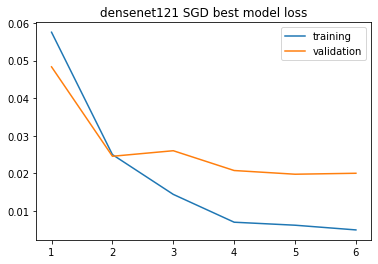

In [161]:
plt.figure()
plt.plot(np.arange(1,7), training_loss, label = "training")
plt.plot(np.arange(1,7), validation_loss, label = "validation")
plt.title("densenet121 SGD best model loss")
plt.legend()

## Fifth model: transfer learning from densenet 121 using RMSprop, lr = 0.0001 with decay gamma = 0.1 and step size 3

In [147]:
torch.manual_seed(1)
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr = 0.0001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [148]:
torch.manual_seed(1)
model, training_loss, validation_loss = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=6)

Epoch 1/6
----------
train_data Loss: 0.0592 Acc: 0.9776
val_data Loss: 0.0433 Acc: 0.9838
Epoch 2/6
----------
train_data Loss: 0.0346 Acc: 0.9877
val_data Loss: 0.0390 Acc: 0.9860
Epoch 3/6
----------
train_data Loss: 0.0255 Acc: 0.9905
val_data Loss: 0.0348 Acc: 0.9890
Epoch 4/6
----------
train_data Loss: 0.0077 Acc: 0.9974
val_data Loss: 0.0280 Acc: 0.9922
Epoch 5/6
----------
train_data Loss: 0.0032 Acc: 0.9990
val_data Loss: 0.0345 Acc: 0.9914
Epoch 6/6
----------
train_data Loss: 0.0023 Acc: 0.9994
val_data Loss: 0.0331 Acc: 0.9924
Best val Acc: 0.992400


In [149]:
FILE = "dogs_vs_cats_densenet121_rmsprop.pth"
torch.save(model.state_dict(),FILE)

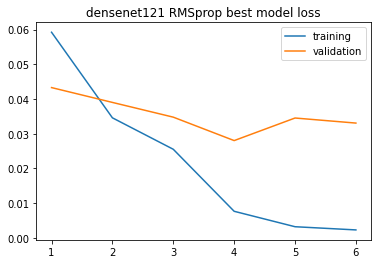

In [151]:
plt.figure()
plt.plot(np.arange(1,7), training_loss, label = "training")
plt.plot(np.arange(1,7), validation_loss, label = "validation")
plt.title("densenet121 RMSprop best model loss")
plt.legend()

## Sixth model: transfer learning from densenet 121 using Adam, lr = 0.00001 with decay gamma = 0.1 and step size 3

In [172]:
torch.manual_seed(1)
model = models.densenet121(pretrained=True)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [173]:
torch.manual_seed(1)
model, training_loss, validation_loss = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=6)

Epoch 1/6
----------
train_data Loss: 0.1075 Acc: 0.9680
val_data Loss: 0.0319 Acc: 0.9902
Epoch 2/6
----------
train_data Loss: 0.0331 Acc: 0.9904
val_data Loss: 0.0237 Acc: 0.9928
Epoch 3/6
----------
train_data Loss: 0.0191 Acc: 0.9943
val_data Loss: 0.0234 Acc: 0.9924
Epoch 4/6
----------
train_data Loss: 0.0110 Acc: 0.9977
val_data Loss: 0.0224 Acc: 0.9926
Epoch 5/6
----------
train_data Loss: 0.0108 Acc: 0.9979
val_data Loss: 0.0215 Acc: 0.9932
Epoch 6/6
----------
train_data Loss: 0.0093 Acc: 0.9978
val_data Loss: 0.0211 Acc: 0.9936
Best val Acc: 0.993600


In [174]:
FILE = "dogs_vs_cats_densenet121_adam.pth"
torch.save(model.state_dict(),FILE)

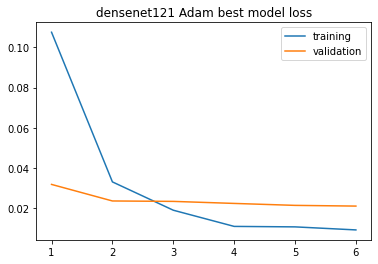

In [175]:
plt.figure()
plt.plot(np.arange(1,7), training_loss, label = "training")
plt.plot(np.arange(1,7), validation_loss, label = "validation")
plt.title("densenet121 Adam best model loss")
plt.legend()

## Prepare data for Inception

In [177]:
torch.manual_seed(1)
train_transform = transforms.Compose([transforms.Resize((299,299)),
                                     transforms.ToTensor(),
                                     transforms.RandomHorizontalFlip(0.5)])

val_transform = transforms.Compose([transforms.Resize((299,299)),
                                     transforms.ToTensor(),
                                    ])

data_transforms = {
    "train_data": train_transform,
    "val_data": val_transform
}

In [178]:
image_datasets = {x: ImageFolder(os.path.join(data_dir,x), transform=data_transforms[x]) for x in ["train_data","val_data"]}

In [179]:
torch.manual_seed(1)
dataloaders = {x: DataLoader(image_datasets[x],batch_size=16,shuffle=True) for x in ["train_data","val_data"]}

## Seventh model: transfer learning from inception v3 using SGD, lr=0.01 with decay gamma = 0.1 and step size 3

In [190]:
torch.manual_seed(1)
model = models.inception_v3(pretrained=True)
model.aux_logits = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [191]:
torch.manual_seed(1)
model, training_loss, validation_loss = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=5)

Epoch 1/5
----------
train_data Loss: 0.0645 Acc: 0.9770
val_data Loss: 0.0276 Acc: 0.9928
Epoch 2/5
----------
train_data Loss: 0.0208 Acc: 0.9925
val_data Loss: 0.0234 Acc: 0.9928
Epoch 3/5
----------
train_data Loss: 0.0100 Acc: 0.9969
val_data Loss: 0.0272 Acc: 0.9920
Epoch 4/5
----------
train_data Loss: 0.0055 Acc: 0.9989
val_data Loss: 0.0198 Acc: 0.9942
Epoch 5/5
----------
train_data Loss: 0.0049 Acc: 0.9988
val_data Loss: 0.0191 Acc: 0.9950
Best val Acc: 0.995000


In [192]:
FILE = "dogs_vs_cats_inceptionv3_sgd.pth"
torch.save(model.state_dict(),FILE)

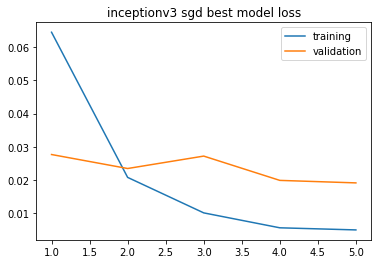

In [193]:
plt.figure()
plt.plot(np.arange(1,6), training_loss, label = "training")
plt.plot(np.arange(1,6), validation_loss, label = "validation")
plt.title("inceptionv3 sgd best model loss")
plt.legend()

## Eighth model: transfer learning from inception v3 using RMSprop, lr = 0.0001 with decay gamma = 0.1 and step size 3

In [199]:
torch.manual_seed(1)
model = models.inception_v3(pretrained=True)
model.aux_logits = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr = 0.0001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [200]:
torch.manual_seed(1)
model, training_loss, validation_loss = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=7)

Epoch 1/7
----------
train_data Loss: 0.0608 Acc: 0.9772
val_data Loss: 0.0544 Acc: 0.9820
Epoch 2/7
----------
train_data Loss: 0.0339 Acc: 0.9878
val_data Loss: 0.0380 Acc: 0.9898
Epoch 3/7
----------
train_data Loss: 0.0283 Acc: 0.9912
val_data Loss: 0.0375 Acc: 0.9882
Epoch 4/7
----------
train_data Loss: 0.0091 Acc: 0.9974
val_data Loss: 0.0396 Acc: 0.9910
Epoch 5/7
----------
train_data Loss: 0.0045 Acc: 0.9988
val_data Loss: 0.0376 Acc: 0.9930
Epoch 6/7
----------
train_data Loss: 0.0023 Acc: 0.9992
val_data Loss: 0.0484 Acc: 0.9920
Epoch 7/7
----------
train_data Loss: 0.0015 Acc: 0.9996
val_data Loss: 0.0404 Acc: 0.9932
Best val Acc: 0.993200


In [201]:
FILE = "dogs_vs_cats_inceptionv3_rmsprop.pth"
torch.save(model.state_dict(),FILE)

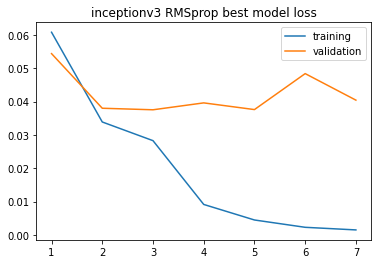

In [202]:
plt.figure()
plt.plot(np.arange(1,8), training_loss, label = "training")
plt.plot(np.arange(1,8), validation_loss, label = "validation")
plt.title("inceptionv3 RMSprop best model loss")
plt.legend()

## Ninth model: transfer learning from inception v3 using Adam, lr = 0.00001 with decay gamma = 0.1 and step size 3

In [205]:
torch.manual_seed(1)
model = models.inception_v3(pretrained=True)
model.aux_logits = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,2)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [206]:
torch.manual_seed(1)
model, training_loss, validation_loss = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=4)

Epoch 1/4
----------
train_data Loss: 0.0944 Acc: 0.9697
val_data Loss: 0.0269 Acc: 0.9916
Epoch 2/4
----------
train_data Loss: 0.0240 Acc: 0.9925
val_data Loss: 0.0227 Acc: 0.9920
Epoch 3/4
----------
train_data Loss: 0.0119 Acc: 0.9964
val_data Loss: 0.0254 Acc: 0.9928
Epoch 4/4
----------
train_data Loss: 0.0054 Acc: 0.9990
val_data Loss: 0.0234 Acc: 0.9928
Best val Acc: 0.992800


In [207]:
FILE = "dogs_vs_cats_inceptionv3_adam.pth"
torch.save(model.state_dict(),FILE)

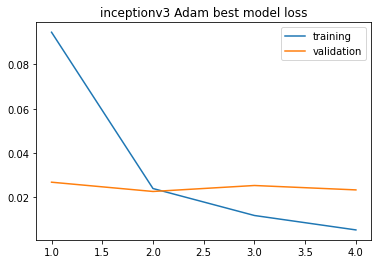

In [208]:
plt.figure()
plt.plot(np.arange(1,5), training_loss, label = "training")
plt.plot(np.arange(1,5), validation_loss, label = "validation")
plt.title("inceptionv3 Adam best model loss")
plt.legend()